# Classifying salaries using Logistic Regression

## Importing our packages / dataset

In [1]:
# Importing Packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

#Data and analysis
import scipy as sp
import os
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import random

In [2]:
# Importing our dataset
df = pd.read_csv("clean_dataset.csv")
df.head()

,Unnamed: 0,Title,Company,Description,Salary,City,State,Pincode,Source
0,0,Data Analyst,Seen by Indeed,With one application you can be considered for...,NaN,Seattle,WA,NaN,Indeed
1,1,Business Analyst,Microsoft6,Microsoft Cloud Hardware Infrastructure and En...,NaN,Redmond,WA,NaN,Indeed
2,2,ML Data Associate III,Amazon.com Services LLC46,Basic Qualifications\nBachelors degree or comm...,NaN,Seattle,WA,NaN,Indeed
3,3,Data Analyst,Gupta Media,Gupta Media is looking for a Data Analyst to j...,NaN,Boston,MA,2116,Indeed
4,4,Implementation Specialist / Business Analyst,ScerIS,ScerIS is looking to add experienced and entry...,92500.0,Marlborough,MA,1752,Indeed


In [3]:
# We will create a salary dataset where there are no null values
salary_data = df[df['Salary'].notnull()]

In [4]:
# Drop the redundant cells
salary_data = salary_data.drop(['Unnamed: 0','Pincode'],axis=1)

# EDA

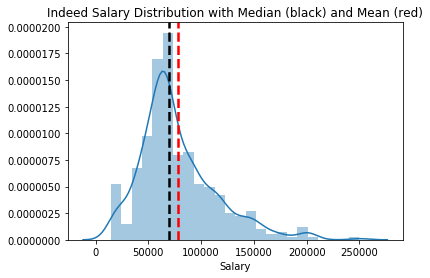

In [5]:
# Let's look at the salary distribution, mean, median values
sal_plot = salary_data[salary_data["Salary"].notnull()]
ax = sns.distplot(salary_data["Salary"])
ax.axvline(salary_data["Salary"].median(), lw=2.5, ls='dashed', color='black')
ax.axvline(salary_data["Salary"].mean(), lw=2.5, ls='dashed', color='red')
plt.title('Indeed Salary Distribution with Median (black) and Mean (red)');

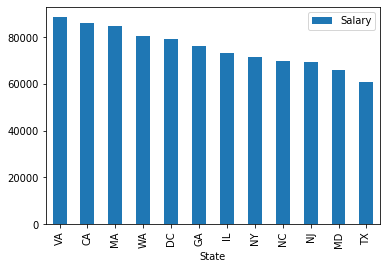

In [6]:
# Salaries per State
salary_data.groupby(['State']).mean().sort_values("Salary", ascending = False).plot.bar();

## Creating our new salary - Above Median and Below Median

In [8]:
# Create a new column stating high salary for anything above the median
salary_data['High Salary'] = salary_data.apply(lambda x: 1 if x['Salary'] > salary_data["Salary"].median() else 0,axis=1)

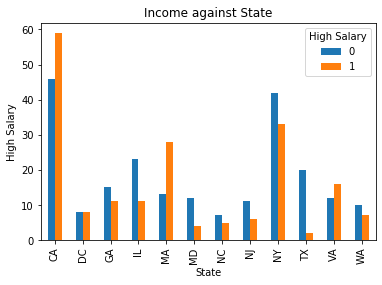

In [10]:
#determining if a variable is good predictor of salary through plots
pd.crosstab(salary_data['State'],salary_data['High Salary']).plot(kind='bar');
plt.title('Income against State');
plt.xlabel('State');
plt.ylabel('High Salary');

# Feature Engineering

## Creating Titles 

In [11]:
def title_function(x):
    if "data scientist" in x or "scien" in x or "machine learning" in x or "ml" in x or "statist" in x or "a.i" in x or "artificial" in x or "nlp" in x or "natural language" in x or "deep learning" in x:
        return "data scientist"
    elif "data analyst" in x or "data" in x:
        return "data analyst"
    elif "business analyst" in x or "business" in x or "intelligence" in x or "bi" in x:
        return "business analyst"
    elif "market" in x:
        return "marketing analyst"
    elif "financ" in x:
        return "financial analyst"
    else: return "others"

salary_data["Modified Title"] = salary_data["Title"].str.lower().apply(title_function)

In [12]:
salary_data['Modified Title'].value_counts()

others               131
business analyst     130
data analyst          86
data scientist        32
financial analyst     17
marketing analyst     13
Name: Modified Title, dtype: int64

## Skills

### Technology

In [13]:
# Create a counter function for the entire dataset
def countkeywords(keyword):
    num = [str(row).lower().count(keyword) for row in salary_data['Description']]
    return keyword,sum(num)

In [14]:
# Creating a customized list of technology skills
technology_skills_list = ['python', ' r ','sql','java','scala','excel',
                          'aws','hadoop','spark','tableau','sas','c++',
                          'linux','hive','oracle','perl','mysql','matlab',
                          'html','tensorflow','spss','mongodb']

In [15]:
# Checking count
technology_skills = []
for word in technology_skills_list:
     technology_skills.append(countkeywords(str(word)))

In [16]:
# Creating our technology skill column
technology_skill = []

for i in range(len(technology_skills)):
    technology_skill.append(technology_skills[i][0])
    
# Creating our technology skill frequency column
technology_skill_freq = []

for i in range(len(technology_skills)):
    technology_skill_freq.append(technology_skills[i][1])
    
# Creating our technology skill dataframe
tech_skills_df = {'Technology_Skill':technology_skill,'Frequency':technology_skill_freq}
tech_skills = pd.DataFrame(tech_skills_df)
tech_skills = tech_skills.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

tech_skills[tech_skills['Frequency'] >= 10]

,Technology_Skill,Frequency
0,excel,444
1,sql,306
2,aws,110
3,python,102
4,tableau,80
5,sas,71
6,java,58
7,scala,54
8,oracle,33
9,mysql,17


In [17]:
salary_data['SQL'] = salary_data["Description"].str.lower().str.contains("sql").astype(int)
salary_data['Python'] = salary_data["Description"].str.lower().str.contains("python").astype(int)
salary_data['Tableau'] = salary_data["Description"].str.lower().str.contains("tableau").astype(int)
salary_data['Excel'] = salary_data["Description"].str.lower().str.contains("excel").astype(int)
salary_data['Scala'] = salary_data["Description"].str.lower().str.contains("scala").astype(int)
salary_data['Java'] = salary_data["Description"].str.lower().str.contains("java").astype(int)
salary_data['Oracle'] = salary_data["Description"].str.lower().str.contains("oracle").astype(int)
salary_data['Hadoop'] = salary_data["Description"].str.lower().str.contains("hadoop").astype(int)
salary_data['Tensorflow'] = salary_data["Description"].str.lower().str.contains("tensorflow").astype(int)
salary_data['AWS'] = salary_data["Description"].str.lower().str.contains("aws").astype(int)
salary_data['SPSS'] = salary_data["Description"].str.lower().str.contains("spss").astype(int)
salary_data['R'] = salary_data["Description"].str.lower().str.contains("r").astype(int)
salary_data['Hive'] = salary_data["Description"].str.lower().str.contains("hive").astype(int)
salary_data['Linux'] = salary_data["Description"].str.lower().str.contains("linux").astype(int)
salary_data['MySQL'] = salary_data["Description"].str.lower().str.contains("mysql").astype(int)
salary_data['Spark'] = salary_data["Description"].str.lower().str.contains("spark").astype(int)
salary_data['SAS'] = salary_data["Description"].str.lower().str.contains("sas").astype(int)

In [19]:
# Create a column for count of technology skills
salary_data['Technology_Skills_Count'] = salary_data['SQL'] + salary_data['Python'] + salary_data['Tableau'] + salary_data['Excel'] + salary_data['Scala'] + salary_data['Java'] + salary_data['Oracle'] + salary_data['Hadoop'] + salary_data['Tensorflow'] + salary_data['AWS'] + salary_data['SPSS'] + salary_data['R'] + salary_data['Hive'] + salary_data['Linux'] + salary_data['MySQL'] + salary_data['Spark'] + salary_data['SAS']   

In [20]:
salary_data.drop(['SQL','Python','Tableau','Excel','Scala','Java','Oracle','Hadoop','Tensorflow','AWS','SPSS','R',
                 'Hive','Linux','MySQL','Spark','SAS'],axis=1,inplace = True)

In [21]:
salary_data.head()

,Title,Company,Description,Salary,City,State,Source,High Salary,Modified Title,Technology_Skills_Count
4,Implementation Specialist / Business Analyst,ScerIS,ScerIS is looking to add experienced and entry...,92500.0,Marlborough,MA,Indeed,1,business analyst,2
38,Entry Level Data Analyst (Information Technology),The Atlantic Group,"ResponsibilitiesInterpret data, analyze result...",41000.0,Boston,MA,Indeed,0,data analyst,1
46,Board Certified Behavior Analyst (BCBA),Aspire Learning Center,"Aspire Learning Center, LLC provides center an...",75000.0,Beverly,MA,Indeed,1,others,2
47,Full Time or Part Time Board Certified Behavio...,Specialized Autism Consultants,We are currently seeking a Full Time or Part-T...,72500.0,Salem,MA,Indeed,1,others,1
54,Board Certified Behavior Analyst (BCBA) / Clin...,Merrimack Autism Consultants LLC,About Us: Merrimack Autism consultants is a pr...,76000.0,Boston,MA,Indeed,1,others,1


### Technical

In [22]:
# Creating a customized list of technical skills
technical_skills_list = ['big data', 'cloud','dashboard','business problem',
         'predictive model','cluster','data manipulation','experimental design',
         'machine learning','data analysis','data visualization',
         'modeling','statistical analysis','research','deep learning',
         'optimization','decision tree','logistic','random forest',
         'a/b testing','web scraping','neural network','regression']

In [23]:
# Creating technical skills count
technical_skills = []
for word in technical_skills_list:
     technical_skills.append(countkeywords(str(word)))

In [24]:
# Creating our technical skill column
technical_skill = []

for i in range(len(technical_skills)):
    technical_skill.append(technical_skills[i][0])
    
# Creating our technical skill frequency column
technical_skill_freq = []

for i in range(len(technical_skills)):
    technical_skill_freq.append(technical_skills[i][1])
    
# Creating our technical skill dataframe
technical_skills_df = {'Technical_Skill':technical_skill,'Frequency':technical_skill_freq}
technical_skills = pd.DataFrame(technical_skills_df)
technical_skills = technical_skills.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

technical_skills[technical_skills['Frequency'] >= 10]

,Technical_Skill,Frequency
0,research,304
1,data analysis,101
2,cloud,95
3,machine learning,88
4,dashboard,64
5,modeling,57
6,logistic,55
7,data visualization,42
8,optimization,41
9,business problem,16


In [25]:
salary_data['Research'] = salary_data["Description"].str.lower().str.contains("research").astype(int)
salary_data['ML'] = salary_data["Description"].str.lower().str.contains("machine learning").astype(int)
salary_data['Regression'] = salary_data["Description"].str.lower().str.contains("regression").astype(int)
salary_data['Cluster'] = salary_data["Description"].str.lower().str.contains("cluster").astype(int)
salary_data['Data Visualization'] = salary_data["Description"].str.lower().str.contains("data visualization").astype(int)
salary_data['Data Analysis'] = salary_data["Description"].str.lower().str.contains("data analysis").astype(int)
salary_data['Modeling'] = salary_data["Description"].str.lower().str.contains("modeling").astype(int)
salary_data['Cloud'] = salary_data["Description"].str.lower().str.contains("cloud").astype(int)
salary_data['Dashboard'] = salary_data["Description"].str.lower().str.contains("dashboard").astype(int)
salary_data['Logistic'] = salary_data["Description"].str.lower().str.contains("logistic").astype(int)
salary_data['Optimization'] = salary_data["Description"].str.lower().str.contains("optimization").astype(int)
salary_data['Business Problem'] = salary_data["Description"].str.lower().str.contains("business problem").astype(int)
salary_data['Deep Learning'] = salary_data["Description"].str.lower().str.contains("deep learning").astype(int)
salary_data['Big Data'] = salary_data["Description"].str.lower().str.contains("big data").astype(int)

In [26]:
salary_data['Technical_Skills_Count'] = salary_data['Research'] + salary_data['ML'] + salary_data['Regression'] + salary_data['Cluster'] + salary_data['Data Visualization'] + salary_data['Data Analysis'] + salary_data['Modeling'] + salary_data['Cloud'] + salary_data['Dashboard'] + salary_data['Logistic'] + salary_data['Optimization'] + salary_data['Business Problem'] + salary_data['Deep Learning'] + salary_data['Big Data'] 

In [27]:
salary_data.drop(['Research','ML','Regression','Cluster','Data Visualization','Data Analysis','Modeling','Cloud',
                  'Dashboard','Logistic','Optimization','Business Problem','Deep Learning','Big Data'],axis=1,inplace = True)

In [28]:
salary_data.head()

,Title,Company,Description,Salary,City,State,Source,High Salary,Modified Title,Technology_Skills_Count,Technical_Skills_Count
4,Implementation Specialist / Business Analyst,ScerIS,ScerIS is looking to add experienced and entry...,92500.0,Marlborough,MA,Indeed,1,business analyst,2,1
38,Entry Level Data Analyst (Information Technology),The Atlantic Group,"ResponsibilitiesInterpret data, analyze result...",41000.0,Boston,MA,Indeed,0,data analyst,1,0
46,Board Certified Behavior Analyst (BCBA),Aspire Learning Center,"Aspire Learning Center, LLC provides center an...",75000.0,Beverly,MA,Indeed,1,others,2,1
47,Full Time or Part Time Board Certified Behavio...,Specialized Autism Consultants,We are currently seeking a Full Time or Part-T...,72500.0,Salem,MA,Indeed,1,others,1,0
54,Board Certified Behavior Analyst (BCBA) / Clin...,Merrimack Autism Consultants LLC,About Us: Merrimack Autism consultants is a pr...,76000.0,Boston,MA,Indeed,1,others,1,0


### Soft Skills

In [29]:
# Creating a customized soft skills list
soft_skills_list = ['problem solving','collaborative','independent','curious','leadership',
      'interpersonal skills','communication skills','client management','team build',
      'storytell']

In [30]:
# Creating a soft skill count
soft_skills = []
for word in soft_skills_list:
     soft_skills.append(countkeywords(str(word)))

In [31]:
# Creating our soft skill column
soft_skill = []

for i in range(len(soft_skills)):
    soft_skill.append(soft_skills[i][0])
    
# Creating our soft skill frequency column
soft_skill_freq = []

for i in range(len(soft_skills)):
    soft_skill_freq.append(soft_skills[i][1])
    
# Creating our soft skill dataframe
soft_skills_df = {'Soft_Skill':soft_skill,'Frequency':soft_skill_freq}
soft_skills = pd.DataFrame(soft_skills_df)
soft_skills = soft_skills.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

soft_skills[soft_skills['Frequency'] >= 10]

,Soft_Skill,Frequency
0,communication skills,169
1,leadership,102
2,independent,100
3,collaborative,87
4,interpersonal skills,51
5,problem solving,44


In [32]:
salary_data['Collaborative'] = salary_data["Description"].str.lower().str.contains("collaborative").astype(int)
salary_data['Communication'] = salary_data["Description"].str.lower().str.contains("communication skills").astype(int)
salary_data['Independent'] = salary_data["Description"].str.lower().str.contains("independent").astype(int)
salary_data['Leadership'] = salary_data["Description"].str.lower().str.contains("leadership").astype(int)
salary_data['Interpersonal Skills'] = salary_data["Description"].str.lower().str.contains("interpersonal skills").astype(int)
salary_data['Problem Solving'] = salary_data["Description"].str.lower().str.contains("problem solving").astype(int)

In [33]:
salary_data['Soft_Skills_Count'] = salary_data['Collaborative'] + salary_data['Communication'] + salary_data['Independent'] + salary_data['Leadership'] + salary_data['Interpersonal Skills'] + salary_data['Problem Solving'] 

In [34]:
salary_data.drop(['Collaborative','Communication','Independent','Leadership','Interpersonal Skills','Problem Solving'],axis=1,inplace = True)


In [35]:
salary_data.head()

,Title,Company,Description,Salary,City,State,Source,High Salary,Modified Title,Technology_Skills_Count,Technical_Skills_Count,Soft_Skills_Count
4,Implementation Specialist / Business Analyst,ScerIS,ScerIS is looking to add experienced and entry...,92500.0,Marlborough,MA,Indeed,1,business analyst,2,1,2
38,Entry Level Data Analyst (Information Technology),The Atlantic Group,"ResponsibilitiesInterpret data, analyze result...",41000.0,Boston,MA,Indeed,0,data analyst,1,0,0
46,Board Certified Behavior Analyst (BCBA),Aspire Learning Center,"Aspire Learning Center, LLC provides center an...",75000.0,Beverly,MA,Indeed,1,others,2,1,1
47,Full Time or Part Time Board Certified Behavio...,Specialized Autism Consultants,We are currently seeking a Full Time or Part-T...,72500.0,Salem,MA,Indeed,1,others,1,0,0
54,Board Certified Behavior Analyst (BCBA) / Clin...,Merrimack Autism Consultants LLC,About Us: Merrimack Autism consultants is a pr...,76000.0,Boston,MA,Indeed,1,others,1,0,0


## Creating Seniority Level

In [36]:
def seniority_function(x):
    if "entry" in x or "jr" in x or "junior" in x or "fresh" in x:
        return "entry level"
    elif "lead" in x or "principal" in x or "senior" in x or "sr" in x or "sr." in x:
        return "lead/principal"
    elif "manager" in x or "director" in x:
        return "manager"
    elif "intern" in x:
        return "intern"
    else: return "others"

salary_data["Seniority"] = salary_data["Title"].str.lower().apply(seniority_function)

In [37]:
salary_data['Seniority'].value_counts()

others            300
entry level        53
lead/principal     33
intern             14
manager             9
Name: Seniority, dtype: int64

## Dummy Variables

In [38]:
factors = ['State', 'Modified Title', 'Seniority', 'High Salary']

In [39]:
salary_data_mod = pd.get_dummies(salary_data, columns = factors)
salary_data_mod.head()

,Title,Company,Description,Salary,City,Source,Technology_Skills_Count,Technical_Skills_Count,Soft_Skills_Count,State_CA,...,Modified Title_financial analyst,Modified Title_marketing analyst,Modified Title_others,Seniority_entry level,Seniority_intern,Seniority_lead/principal,Seniority_manager,Seniority_others,High Salary_0,High Salary_1
4,Implementation Specialist / Business Analyst,ScerIS,ScerIS is looking to add experienced and entry...,92500.0,Marlborough,Indeed,2,1,2,0,...,0,0,0,0,0,0,0,1,0,1
38,Entry Level Data Analyst (Information Technology),The Atlantic Group,"ResponsibilitiesInterpret data, analyze result...",41000.0,Boston,Indeed,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
46,Board Certified Behavior Analyst (BCBA),Aspire Learning Center,"Aspire Learning Center, LLC provides center an...",75000.0,Beverly,Indeed,2,1,1,0,...,0,0,1,0,0,0,0,1,0,1
47,Full Time or Part Time Board Certified Behavio...,Specialized Autism Consultants,We are currently seeking a Full Time or Part-T...,72500.0,Salem,Indeed,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
54,Board Certified Behavior Analyst (BCBA) / Clin...,Merrimack Autism Consultants LLC,About Us: Merrimack Autism consultants is a pr...,76000.0,Boston,Indeed,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1


In [40]:
drop_col = ['Title', 'Company', 'Description', 'Salary', 'Source',
            'City', 'High Salary_0', 'State_VA', 
            'Seniority_others', 'Modified Title_others']

In [41]:
salary_data_mod = salary_data_mod.drop(drop_col, axis=1)
salary_data_mod.head()

,Technology_Skills_Count,Technical_Skills_Count,Soft_Skills_Count,State_CA,State_DC,State_GA,State_IL,State_MA,State_MD,State_NC,...,Modified Title_business analyst,Modified Title_data analyst,Modified Title_data scientist,Modified Title_financial analyst,Modified Title_marketing analyst,Seniority_entry level,Seniority_intern,Seniority_lead/principal,Seniority_manager,High Salary_1
4,2,1,2,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
38,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
46,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
47,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
54,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [42]:
corrdf = salary_data_mod.corr()
corrdf['High Salary_1'].sort_values(ascending=False)

High Salary_1                       1.000000
Seniority_lead/principal            0.246059
Modified Title_data scientist       0.148494
State_MA                            0.146152
State_CA                            0.114723
Technical_Skills_Count              0.099446
Seniority_manager                   0.094206
Technology_Skills_Count             0.033763
State_DC                            0.014343
Modified Title_data analyst         0.000588
Modified Title_business analyst    -0.014647
State_NC                           -0.016691
State_GA                           -0.021665
State_WA                           -0.022039
State_NY                           -0.023323
Modified Title_financial analyst   -0.046601
State_NJ                           -0.046601
State_IL                           -0.085138
State_MD                           -0.086798
Soft_Skills_Count                  -0.131811
Modified Title_marketing analyst   -0.168764
Seniority_intern                   -0.175356
State_TX  

In [43]:
# Fill up with ones you want to keep (keep all for now)
keepers = list(salary_data_mod.columns.values)

In [44]:
salary_data_mod = salary_data_mod[keepers]
salary_data_mod.info() #select the high correlation variables

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409 entries, 4 to 28315
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   Technology_Skills_Count           409 non-null    int32
 1   Technical_Skills_Count            409 non-null    int32
 2   Soft_Skills_Count                 409 non-null    int32
 3   State_CA                          409 non-null    uint8
 4   State_DC                          409 non-null    uint8
 5   State_GA                          409 non-null    uint8
 6   State_IL                          409 non-null    uint8
 7   State_MA                          409 non-null    uint8
 8   State_MD                          409 non-null    uint8
 9   State_NC                          409 non-null    uint8
 10  State_NJ                          409 non-null    uint8
 11  State_NY                          409 non-null    uint8
 12  State_TX                          

# Test-Training Set Split and Fitting

## Skills

In [45]:
X0 = salary_data_mod.iloc[:,0:3] 
X0 = X0.loc[:, X0.columns != 'High Salary_1']
X0

,Technology_Skills_Count,Technical_Skills_Count,Soft_Skills_Count
4,2,1,2
38,1,0,0
46,2,1,1
47,1,0,0
54,1,0,0
...,...,...,...
27984,2,1,2
28176,2,0,0
28249,2,0,0
28273,3,0,0


In [46]:
Y0 = salary_data_mod.loc[:, salary_data_mod.columns == 'High Salary_1']

In [47]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.3, random_state=1) 

In [49]:
logreg = LogisticRegression()
logreg.fit(X0_train, Y0_train) #model fitting

C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
Y0_pred = logreg.predict(X0_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X0_test, Y0_test)))

Accuracy of logistic regression classifier on test set: 0.52


In [51]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y0_test, Y0_pred)
print(confusion_matrix) #correction prediction(6989+992), incorrect prediction(561+1227)

[[48 10]
 [49 16]]


In [52]:
from sklearn.metrics import classification_report
print(classification_report(Y0_test, Y0_pred))

              precision    recall  f1-score   support

           0       0.49      0.83      0.62        58
           1       0.62      0.25      0.35        65

    accuracy                           0.52       123
   macro avg       0.56      0.54      0.49       123
weighted avg       0.56      0.52      0.48       123



## States

In [53]:
X0 = salary_data_mod.iloc[:,3:14]
X0

,State_CA,State_DC,State_GA,State_IL,State_MA,State_MD,State_NC,State_NJ,State_NY,State_TX,State_WA
4,0,0,0,0,1,0,0,0,0,0,0
38,0,0,0,0,1,0,0,0,0,0,0
46,0,0,0,0,1,0,0,0,0,0,0
47,0,0,0,0,1,0,0,0,0,0,0
54,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
27984,0,0,0,0,0,0,0,0,1,0,0
28176,0,0,0,0,0,0,1,0,0,0,0
28249,0,0,0,0,0,0,0,0,0,1,0
28273,0,0,0,0,0,0,1,0,0,0,0


In [54]:
Y0 = salary_data_mod.loc[:, salary_data_mod.columns == 'High Salary_1']

In [55]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.3, random_state=1) 

In [56]:
logreg = LogisticRegression()
logreg.fit(X0_train, Y0_train) #model fitting

C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
Y0_pred = logreg.predict(X0_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X0_test, Y0_test)))

Accuracy of logistic regression classifier on test set: 0.55


In [58]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y0_test, Y0_pred)
print(confusion_matrix) #correction prediction(6989+992), incorrect prediction(561+1227)

[[39 19]
 [36 29]]


In [59]:
from sklearn.metrics import classification_report
print(classification_report(Y0_test, Y0_pred))

              precision    recall  f1-score   support

           0       0.52      0.67      0.59        58
           1       0.60      0.45      0.51        65

    accuracy                           0.55       123
   macro avg       0.56      0.56      0.55       123
weighted avg       0.56      0.55      0.55       123



## Title

In [60]:
X0 = salary_data_mod.iloc[:,14:19]
X0

,Modified Title_business analyst,Modified Title_data analyst,Modified Title_data scientist,Modified Title_financial analyst,Modified Title_marketing analyst
4,1,0,0,0,0
38,0,1,0,0,0
46,0,0,0,0,0
47,0,0,0,0,0
54,0,0,0,0,0
...,...,...,...,...,...
27984,0,0,0,0,0
28176,0,0,0,1,0
28249,0,0,0,0,0
28273,0,0,0,0,0


In [61]:
Y0 = salary_data_mod.loc[:, salary_data_mod.columns == 'High Salary_1']

In [62]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.3, random_state=1) 

In [65]:
logreg = LogisticRegression()
logreg.fit(X0_train, Y0_train) #model fitting

C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
Y0_pred = logreg.predict(X0_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X0_test, Y0_test)))

Accuracy of logistic regression classifier on test set: 0.50


In [67]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y0_test, Y0_pred)
print(confusion_matrix) #correction prediction(6989+992), incorrect prediction(561+1227)

[[56  2]
 [59  6]]


In [68]:
from sklearn.metrics import classification_report
print(classification_report(Y0_test, Y0_pred))

              precision    recall  f1-score   support

           0       0.49      0.97      0.65        58
           1       0.75      0.09      0.16        65

    accuracy                           0.50       123
   macro avg       0.62      0.53      0.41       123
weighted avg       0.63      0.50      0.39       123



## Seniority 

In [69]:
X0 = salary_data_mod.iloc[:,19:23]
X0

,Seniority_entry level,Seniority_intern,Seniority_lead/principal,Seniority_manager
4,0,0,0,0
38,1,0,0,0
46,0,0,0,0
47,0,0,0,0
54,0,0,0,0
...,...,...,...,...
27984,0,0,0,0
28176,0,0,0,0
28249,0,0,0,0
28273,0,0,0,0


In [70]:
Y0 = salary_data_mod.loc[:, salary_data_mod.columns == 'High Salary_1']

In [71]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.3, random_state=1) 

In [72]:
logreg = LogisticRegression()
logreg.fit(X0_train, Y0_train) #model fitting

C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
Y0_pred = logreg.predict(X0_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X0_test, Y0_test)))

Accuracy of logistic regression classifier on test set: 0.55


In [74]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y0_test, Y0_pred)
print(confusion_matrix) #correction prediction(6989+992), incorrect prediction(561+1227)

[[57  1]
 [54 11]]


In [75]:
from sklearn.metrics import classification_report
print(classification_report(Y0_test, Y0_pred))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67        58
           1       0.92      0.17      0.29        65

    accuracy                           0.55       123
   macro avg       0.72      0.58      0.48       123
weighted avg       0.73      0.55      0.47       123



## All

In [76]:
X0 = salary_data_mod.iloc[:,0:23]
X0

,Technology_Skills_Count,Technical_Skills_Count,Soft_Skills_Count,State_CA,State_DC,State_GA,State_IL,State_MA,State_MD,State_NC,...,State_WA,Modified Title_business analyst,Modified Title_data analyst,Modified Title_data scientist,Modified Title_financial analyst,Modified Title_marketing analyst,Seniority_entry level,Seniority_intern,Seniority_lead/principal,Seniority_manager
4,2,1,2,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
38,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
46,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
47,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
54,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27984,2,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28176,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
28249,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28273,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [77]:
Y0 = salary_data_mod.loc[:, salary_data_mod.columns == 'High Salary_1']

In [78]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.3, random_state=1) 

In [80]:
logreg = LogisticRegression()
logreg.fit(X0_train, Y0_train) #model fitting

C:\Users\vardh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
Y0_pred = logreg.predict(X0_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X0_test, Y0_test)))

Accuracy of logistic regression classifier on test set: 0.67


In [82]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y0_test, Y0_pred)
print(confusion_matrix) #correction prediction(6989+992), incorrect prediction(561+1227)

[[44 14]
 [27 38]]


In [83]:
from sklearn.metrics import classification_report
print(classification_report(Y0_test, Y0_pred))

              precision    recall  f1-score   support

           0       0.62      0.76      0.68        58
           1       0.73      0.58      0.65        65

    accuracy                           0.67       123
   macro avg       0.68      0.67      0.67       123
weighted avg       0.68      0.67      0.66       123



In [84]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
plt.rc("font", size=14)

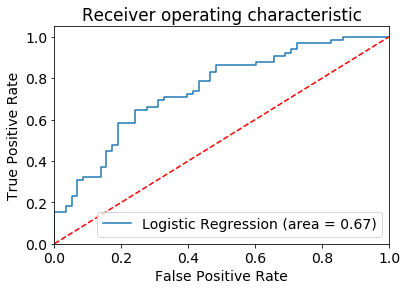

In [85]:
logit_roc_auc = roc_auc_score(Y0_test, logreg.predict(X0_test))
fpr, tpr, thresholds = roc_curve(Y0_test, logreg.predict_proba(X0_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show() #ROC curve stays above average line. the model is good.